<a href="https://colab.research.google.com/github/sri-spirited/fastai_course_v3_notes/blob/master/1_1_ImageRecognition_PetClassification_fastai_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1 - What's your pet

Notes [here](https://github.com/s-totally/notes/blob/master/Lesson1.md)

Video here: 

https://course.fast.ai/videos/?lesson=1

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

The [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/)  sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). 

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import numpy as np

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [0]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



Call the dataset `PETS` from the fastai datasets.
URL is the fastai class that contains the URLs of datasets and models.

In [0]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
#path = untar_data(URLs.PETS); path

PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet')

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

* The main difference between the handling of image classification datasets is the way labels are stored.
* In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. 
* The fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [0]:
fnames = get_image_files(path_img) # Get an array of all the image files in `path_img`
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Birman_154.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_157.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_41.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_129.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_199.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

What this means: 
* /([^/]+)_\d+.jpg __$__ :Dollar sign at end means this is the end of the text we are interpreting

* /([^/]+)_\d+.__jpg__$: Looks for the set of characters 'jpg'

*/([^/]+)___\d__+.jpg$: Looks for numerical digits preceded by underscore. The plus sign + after it means there can be arbitrarily many digits 

* /__([^/]+)___\d+.jpg$: Round brackets mean we are now defining a group of characters. Within the group, we define a set of characters using []. ^ is negation, so we are not looking for forward slash (/)

* /([^/]+)_\d+.jpg$


In [0]:
pat

'/([^/]+)_\\d+.jpg$'

Extract labels from filenames `fnames` from location `path_img`, using the regex search pattern `pat` and working with images of size 224. (Note: GPU has to apply the same instructions to all images, and it cant do that if they're all different sizes. So we make them all size=224)

Returns a __DataBunch__ object:
1. Contains 2 or 3 datasets: train, validation and test data 
2. For each of these datasets, contains images+labels, or text+labels, or tabular data+labels

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

In [0]:
data

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Birman,basset_hound,Ragdoll,pomeranian,pomeranian
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Sphynx,english_cocker_spaniel,scottish_terrier,havanese,leonberger
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

In [0]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

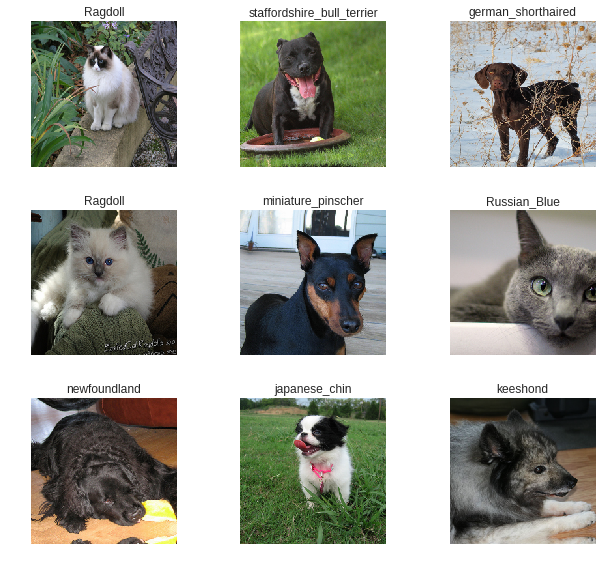

In [0]:
data.show_batch(rows=3, figsize=(9,8))

In [0]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate) # reset34 and resnet50

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 94292798.47it/s]


In [0]:
learn.model

In [0]:
%%timeit
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.393633,0.305987,0.087957
2,0.556555,0.211903,0.066982
3,0.348447,0.192682,0.063599
4,0.270644,0.191649,0.066306


In [0]:
learn.save('stage-1')

## Results

In [0]:
doc(create_cnn)

In [0]:
  interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

Show images in `top_losses` with prediction, actual, loss, prob of actual class

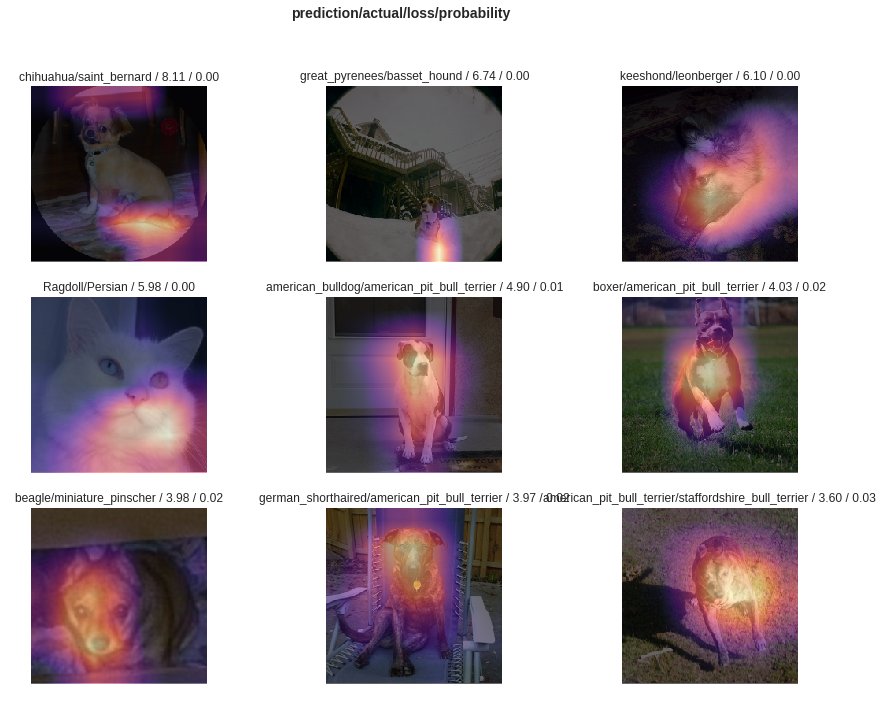

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
doc(interp.plot_top_losses)

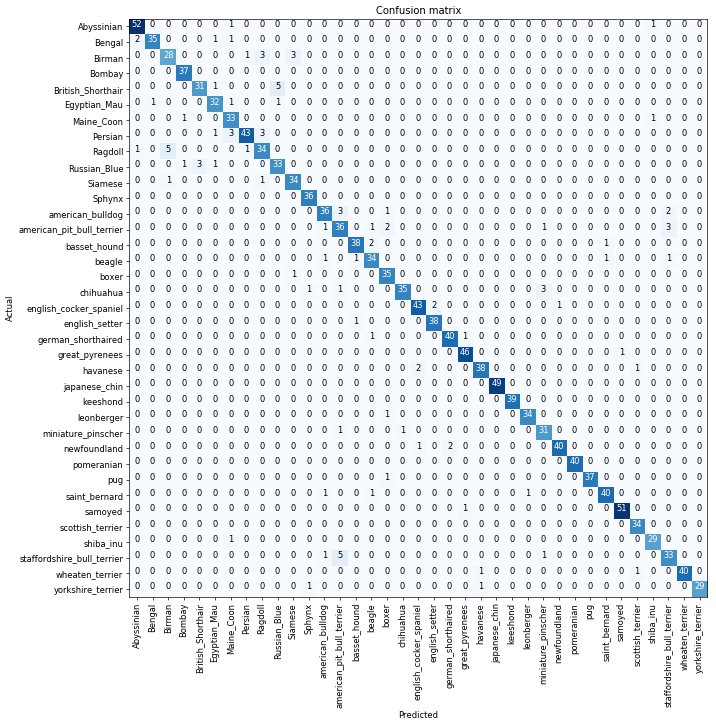

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=2) # Prints actual, predicted and no. of occurences

[('Ragdoll', 'Birman', 6),
 ('Egyptian_Mau', 'Bengal', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Abyssinian', 'Russian_Blue', 3),
 ('Bengal', 'Egyptian_Mau', 3),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Siamese', 'Birman', 3),
 ('american_bulldog', 'boxer', 3)]

In [0]:
help(interp.most_confused)

Help on method most_confused in module fastai.train:

most_confused(min_val:int=0, slice_size:int=1) -> Collection[Tuple[str, str, int]] method of fastai.train.ClassificationInterpretation instance
    Sorted descending list of largest non-diagonal entries of confusion matrix, presented as actual, predicted, number of occurrences.



## Unfreezing, fine-tuning, and learning rates

The pre-trained model already had weights earlier, we only added a few extra layers to the end and trained those. 

We have confirmed that our model is working as we expect it to, so now we will *unfreeze* our model and train some more.

This is a 2-stage approach:
1.   `fit_one_cycle()` on a ConvLearner to fine-tune the extra layers added at the end 
2.   `unfreeze` and then `fit_one_cycle` again 



In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.505964,0.302713,0.100135


Fine-tuning with unfreezing didn't work too well here because we even re-trained the first few layers, which are already good at capturing simple features like lines, angles, corners etc.

Let's reload the model 

In [0]:
learn.load('stage-1');

In [0]:
%%timeit
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
1 loop, best of 3: 1min 15s per loop


Min numerical gradient: 4.79E-06


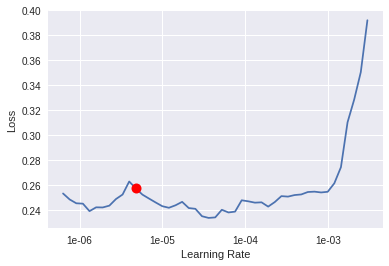

In [0]:
learn.recorder.plot()

https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

Clearly after we cross 4.79E-06, the loss gets worse.

The default learning rate for the model is 0.003 which is obviously too high.

The graph tells us that the earliest point after which the loss started getting worse was 1e-06. But the initial layers were doing well even at a higher learning rate, so lets start quick and then decrease the learning rate.

Lets train the first layer slowly at 1e-04 and the last layer faster at 1e-06 and distribute all the other layers across that. `slice` in python does this given a start and stop value.

__Rule of thumb__: After you unfreeze:
<font color='green'> `max_lr(slice(`start_value, 1/10th of start_value`))` </font>

<font color='red'> **Overview of learning rates and `freeze()`**  </font>

`freeze` and `unfreeze`  allow you to decide which specific layers of your model you want to train at a given time. This is done because we often use transfer learning, and the early layers of our model are already going to be well trained to doing what they do, recognizing basic lines, patterns, gradients…etc, but the later ones (which are more specific to our exact task, like identifying an animal breed) will need more training.

**`unfreeze`** will unfreeze all layers of your model, so you will be training the early and later layers, although you still may be training the different layer groups at different learning rates. This is called ‘discriminative learning rates’ or ‘discriminative layer training’.

**`freeze`** will set all of your layer groups except the last one to be untrainable. This means we freeze the first layer group (the one that comes from transfer learning) and unfreeze the second (also last) group, to train more.

If you know the details of your architecture and want to do something in between unfreeze and freeze you can use freeze_to(n:int) to specify which layer groups you want to freeze and which you want to train. The first n layer groups will be frozen and the last n layer groups will be unfrozen.



In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.223128,0.187052,0.062923
2,0.206534,0.182173,0.062923


That's a pretty accurate model!

## Training: resnet50

Now we will train using [resnet50](https://arxiv.org/pdf/1512.03385.pdf).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 97421407.96it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03


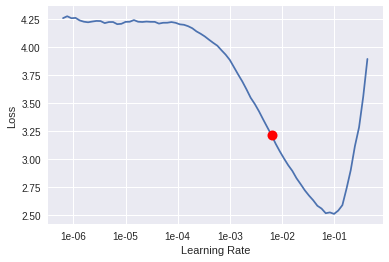

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
%%time
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate
1,0.729732,0.304628,0.092016
2,0.414201,0.241594,0.079838
3,0.332854,0.247318,0.077131
4,0.277956,0.235152,0.089310
5,0.212040,0.206894,0.067659
6,0.144557,0.182649,0.062923
7,0.120509,0.175788,0.060217
8,0.088853,0.170966,0.059540


CPU times: user 9min 28s, sys: 6min 30s, total: 15min 59s
Wall time: 27min 34s


In [0]:
learn.save('stage-1-50')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('Ragdoll', 'Birman', 4),
 ('Russian_Blue', 'British_Shorthair', 4),
 ('staffordshire_bull_terrier', 'american_bulldog', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Maine_Coon', 'Bengal', 3),
 ('Siamese', 'Birman', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3)]

Let's see if full fine-tuning helps:

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.098645,0.185356,0.060217
2,0.089287,0.168599,0.055480
3,0.082603,0.164652,0.054804


If it doesn't, you can always go back to your previous model.

In [0]:
#learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 6),
 ('staffordshire_bull_terrier', 'american_bulldog', 5),
 ('Ragdoll', 'Birman', 4),
 ('Russian_Blue', 'British_Shorthair', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Maine_Coon', 'Bengal', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('beagle', 'basset_hound', 3)]

## Other data formats

In [0]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

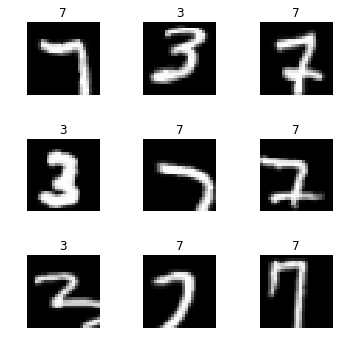

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [0]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

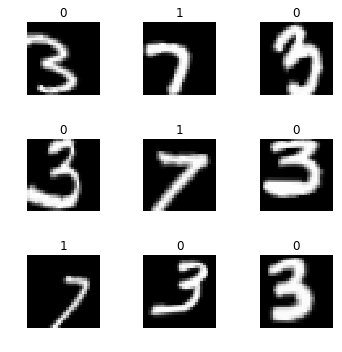

In [0]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [0]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [0]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [0]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [0]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [0]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']